# Modelo de Logit Mixto (MXL): Experimentos de Elección

En este notebook, estimaremos un modelo Logit Mixto (MXL) para conocer las preferencias por el Swissmetro. El modelo de Logit Mixto es una extension al modelo Logit Multinomial, en el cual algunos parametros se asumen aleatorios.

Ademas de estimar parametros aleatorios, estimaremos el modelo MXL utilizando estructura de panel, dado que cada individuo respondio dos o mas situaciones de eleccion. Al considerar estructura de panel, reducimos sesgo generado por el hecho que varias situaciones de eleccion son respondidas por una misma persona.

## Parte 1: Preparacion de los datos

### Importar modulos

El siguiente codigo permite importar los siguientes paquetes de Python:

- `Pandas`: Permite importar y manejar bases de datos
- `Biogeme`: Estimar modelos de eleccion

In [1]:
# Instalar paquetes recomendados
!pip3 install biogeme

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [12]:
# Importar modulos

import pandas as pd
import numpy as np

import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from scipy.stats import norm
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

import matplotlib.pyplot as plt

### Abrir base de datos

La base de datos `swissmetro.dat` es un archivo de texto que contiene la siguiente informacion relevante:

- `ID`: Identificador de cada individuo que responde la encuesta
- `PURPOSE`: Proposito del viaje (1 = trabajo / 3 = negocios)
- `CHOICE`: Alternativa elegida en el experimento (0 = desconocido / 1 = tren / 2 = Swissmetro / 3 = automovil)

Los atributos de las alternativas son:

- `TRAIN_TT`: Tiempo de viaje del tren
- `TRAIN_CO`: Costo de viaje del tren
- `TRAIN_HE`: Frecuencia del tren (1 tren cada `TRAIN_HE` minutos)
- `SM_TT`: Tiempo de viaje del Swissmetro
- `SM_CO`: Costo de viaje del Swissmetro
- `SM_HE`: Frecuencia del Swissmetro (1 frecuencia cada `SM_HE` minutos)
- `CAR_TT`: Tiempo de viaje del automovil
- `CAR_CO`: Costo de viaje del automovil

Ademas, la base cuenta con las variables `TRAIN_AV`, `SM_AV` y `CAR_AV` que indican si la situacion de eleccion contiene la alternativa del tren, Swissmetro y automovil respectivamente.

El siguiente codigo abre y presenta la base de datos:

In [3]:
df = pd.read_table('https://raw.githubusercontent.com/ighdez/taller_UNALM/main/taller_ee/swissmetro.dat')
df

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,2,0,1,1,1,0,1,1,0,3,...,112,48,120,63,52,20,0,117,65,2
1,2,0,1,1,1,0,1,1,0,3,...,103,48,30,60,49,10,0,117,84,2
2,2,0,1,1,1,0,1,1,0,3,...,130,48,60,67,58,30,0,117,52,2
3,2,0,1,1,1,0,1,1,0,3,...,103,40,30,63,52,20,0,72,52,2
4,2,0,1,1,1,0,1,1,0,3,...,130,36,60,63,42,20,0,90,84,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723,3,1,1,1192,4,1,7,1,0,5,...,148,13,30,93,17,30,0,156,56,2
10724,3,1,1,1192,4,1,7,1,0,5,...,148,12,30,96,16,10,0,96,70,3
10725,3,1,1,1192,4,1,7,1,0,5,...,148,16,60,93,16,20,0,96,56,3
10726,3,1,1,1192,4,1,7,1,0,5,...,178,16,30,96,17,30,0,96,91,2


### Inicializar la base de datos, excluir variables y definir estructura de panel

El siguiente codigo inicializa la base de datos y define `ID` como variable identificadora de individuos:

In [4]:
database = db.Database('swissmetro', df)
globals().update(database.variables)
database.panel("ID")

Solo utilizaremos la informacion de las personas que viajan con proposito de trabajo o negocios. Ademas, excluiremos las observaciones con elecciones desconocidas:

In [5]:
exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
database.remove(exclude)

### Definir parametros:

Definiremos tres parametros de atributos:

- `B_COST`: Parametro asociado al costo de viaje
- `B_TIME`: Parametro asociado al tiempo de viaje
- `B_HE`: Parametro asociado a la frecuencia del transporte publico

Definiremos tres constantes por alternativa:

- `ASC_TRAIN`: Constante para la alternativa tren.
- `ASC_SM`: Constante para la alternativa Swissmetro. Sera la categoria base, por lo que sera fija en cero (no estimada)
- `ASC_CAR`: Constante para alternativa automovil.

Asumiremos que el parametro de tiempo de viaje es alearorio. Para ello, crearemos un parametro adicional que captura la desviacion estandar de `B_TIME`. El parametro aleatorio final sera `B_TIME_RND`, que sera construido como `ASC_SM + ASC_SM_S * bioDraws`. `bioDraws` permite generar una simulacion de numeros aleatorios para crear el parametro aleatorio final. Al definir el parametro aleatorio como `ASC_SM + ASC_SM_S * bioDraws`, se asume que `B_TIME_RND` distribuye de forma normal con media `B_TIME` y desviacion estandar `ASC_SM_S`.

In [6]:
# Parametros fijos
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
ASC_SM = Beta('ASC_SM', 0, None, None, 1)
B_COST = Beta('B_COST', 0, None, None, 0)
B_HE = Beta('B_HE', 0, None, None, 0)

# Parametros aleatorios
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_TIME_S = Beta('B_TIME_S', 0.1, None, None, 0)
B_TIME_RND = B_TIME + B_TIME_S * bioDraws('B_TIME_RND', 'NORMAL_ANTI')

### Escalar variables

Para facilidad de interpretacion y estimacion, se recomenda escalar variables con rango amplio. El siguiente codigo permite definir nuevas variables escaladas:

In [7]:
TRAIN_TT_SCALED = TRAIN_TT / 100
TRAIN_COST_SCALED = TRAIN_CO / 100
SM_TT_SCALED = SM_TT / 100
SM_COST_SCALED = SM_CO / 100
CAR_TT_SCALED = CAR_TT / 100
CAR_CO_SCALED = CAR_CO / 100

### Crear funciones de utilidad

En este caso, crearemos funciones de utilidad para cada alternativa. Cada funcion de utilidad esta definida por el tiempo y costo de viaje, mas una constante. Ademas, las funciones de utilidad para tren y Swissmetro tienen frecuencia como atributo adicional.

Recordar que cada funcion de utilidad debe ir asociada a una alternativa de la variable de eleccion (`CHOICE`):

In [8]:
# Crear funciones de utilidad
V1 = ASC_TRAIN + B_TIME_RND * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED + B_HE * TRAIN_HE
V2 = ASC_SM + B_TIME_RND * SM_TT_SCALED + B_COST * SM_COST_SCALED + B_HE * SM_HE
V3 = ASC_CAR + B_TIME_RND * CAR_TT_SCALED + B_COST * CAR_CO_SCALED

# Asociar funciones de utilidad a alternativas
V = {1: V1, 2: V2, 3: V3}



### Crear condiciones de disponibilidad.

En esta base de datos, algunos encuestados enfrentaron menos de tres alternativas. Las variables  `TRAIN_AV`, `SM_AV` y `CAR_AV` indican si la situacion de eleccion contiene la alternativa del tren, Swissmetro y automovil respectivamente. El siguiente codigo permite asociar alternativas con las variables de disponibilidad:

In [9]:
av = {1: TRAIN_AV, 2: SM_AV, 3: CAR_AV}

### Inicializar y estimar el modelo Logit Mixto

El modelo Logit Mixto es un modelo MNL que requiere de las funciones de utilidad, las condiciones de disponibilidad y la variable de eleccion. Luego, se considera la estructura de panel del modelo. Finalmente, se genera la rutina de simulacion y se estima el modelo Logit Mixto:

In [10]:
obsprob = models.logit(V, av, CHOICE)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))
logger = msg.bioMessage()
logger.setGeneral()
biogeme = bio.BIOGEME(database, logprob, numberOfDraws=1000)
biogeme.modelName = 'mxl'
results = biogeme.estimate()

[20:43:43] < General >   Remove 16 unused variables from the database as only 13 are used.
[20:43:44] < General >   *** Initial values of the parameters are obtained from the file __mxl.iter
[20:43:44] < Warning >   Cannot read file __mxl.iter. Statement is ignored.
[20:44:21] < General >   Log likelihood (N = 752):  -6922.143 Gradient norm:      8e+04 Hessian norm:       8e+06 
[20:45:30] < General >   Log likelihood (N = 752):  -5358.015 Gradient norm:      2e+04 Hessian norm:       4e+06 
[20:46:33] < General >   Log likelihood (N = 752):  -4839.573 Gradient norm:      4e+03 Hessian norm:       3e+06 
[20:47:35] < General >   Log likelihood (N = 752):  -4663.335 Gradient norm:      5e+02 Hessian norm:       2e+06 
[20:48:28] < General >   Log likelihood (N = 752):  -4615.236 Gradient norm:      4e+01 Hessian norm:       2e+06 
[20:49:29] < General >   Log likelihood (N = 752):  -4606.663 Gradient norm:      3e+01 Hessian norm:       2e+06 
[20:50:23] < General >   Log likelihood (N 

### Presentacion de resultados

El siguiente codigo permite estimar resultados:

In [11]:
pandasResults = results.getEstimatedParameters()
pandasResults

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,0.598238,0.059003,10.139044,0.000000e+00,0.115680,5.171504,2.322171e-07
ASC_TRAIN,-0.014343,0.091312,-0.157073,8.751874e-01,0.138001,-0.103932,9.172235e-01
B_COST,0.033095,0.003741,8.845602,0.000000e+00,0.006492,5.097861,3.435128e-07
B_HE,-0.006340,0.001215,-5.218325,1.805481e-07,0.001140,-5.562014,2.666790e-08
B_TIME,-3.108142,0.155602,-19.974893,0.000000e+00,0.173576,-17.906535,0.000000e+00
B_TIME_S,3.655674,0.161544,22.629539,0.000000e+00,0.205313,17.805364,0.000000e+00


### Distribucion de preferencias por tiempo

Dado que el tiempo de viaje está asociado a un parametro aleatorio, podemos calcular la distribución de preferencias y ver qué proporcion de personas prefiere el atributo.

El siguiente codigo permite generar la distribucion para un rango de valores

In [15]:
# Guardar parametros
b_time = pandasResults['Value']['B_TIME']
b_time_s = pandasResults['Value']['B_TIME_S']

# Crear rango de valores del parametro (100 valores entre -4 y 4)
x = np.linspace(-10,4,100)

# Crear valores de la distribucion normal en el rango
b_time_rnd = norm.pdf(x,loc=b_time,scale=b_time_s)

El siguiente codigo permite graficar la distribución:

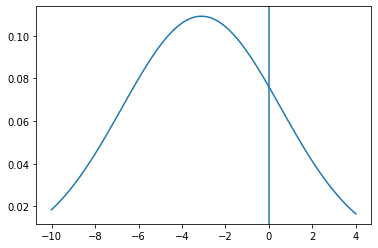

In [16]:
plt.plot(x,b_time_rnd)
plt.axvline(0)

Finalmente, el siguiente codigo permite calcular la proporcion de personas que prefieren el atributo:

In [17]:
print(1-norm.cdf(0,loc=b_time,scale=b_time_s))

0.19760027602203967


Por lo tanto, solo 20% de las personas prefiere el atributo

## Ejercicios:

1. Calcule la disposicion a pagar por mayor frecuencia y menor tiempo de viaje utilizando la formula general. Asuma que el parametro de tiempo no es aleatorio.